# Step 1: Setup & Dependencies

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Define paths
IMAGE_DIR = '/content/gdrive/MyDrive/MultimodalAnalysis/MemeDataset/images'
CSV_PATH = '/content/gdrive/MyDrive/MultimodalAnalysis/MemeDataset/images_description.csv'

Mounted at /content/gdrive


# Step 2: CLAHE Function (Luminance-based for RGB)

In [2]:
def apply_clahe(image, clip_limit=2.0, tile_size=(8, 8)):
    """Applies CLAHE to the luminance channel (preserves colors)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    v_clahe = clahe.apply(v)

    hsv_clahe = cv2.merge((h, s, v_clahe))
    return cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2BGR)

# Step 3: Image Augmentation Functions

In [3]:
def augment_image(image):
    """Applies random augmentations."""
    augmented_images = []

    # Horizontal Flip
    h_flip = cv2.flip(image, 1)
    augmented_images.append(h_flip)

    # Vertical Flip
    v_flip = cv2.flip(image, 0)
    augmented_images.append(v_flip)

    # Rotation (90° clockwise)
    rot = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    augmented_images.append(rot)

    # Random Crop (10% crop)
    h, w = image.shape[:2]
    crop_h, crop_w = int(h * 0.9), int(w * 0.9)
    y = np.random.randint(0, h - crop_h)
    x = np.random.randint(0, w - crop_w)
    crop = image[y:y + crop_h, x:x + crop_w]
    crop = cv2.resize(crop, (w, h))  # Resize back to original dimensions
    augmented_images.append(crop)

    return augmented_images

# Step 4: Process Dataset & Update CSV

In [4]:
def process_dataset():
    # Load CSV
    df = pd.read_csv(CSV_PATH)
    new_rows = []

    # Process each image
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
        img_path = os.path.join(IMAGE_DIR, row['image_name'])

        # Read and apply CLAHE
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip corrupt images

        clahe_img = apply_clahe(img)
        cv2.imwrite(img_path, clahe_img)  # Overwrite with CLAHE-enhanced image

        # Generate augmentations
        augmented_imgs = augment_image(clahe_img)

        # Save augmented images and update CSV
        for i, aug_img in enumerate(augmented_imgs):
            aug_name = f"aug_{i}_{row['image_name']}"
            aug_path = os.path.join(IMAGE_DIR, aug_name)
            cv2.imwrite(aug_path, aug_img)

            # Add new row to CSV
            new_rows.append({
                'image_name': aug_name,
                'Captions': row['Captions'],
                'Label': row['Label']
            })

    # Append new rows to DataFrame
    new_df = pd.DataFrame(new_rows)
    updated_df = pd.concat([df, new_df], ignore_index=True)

    # Save updated CSV
    updated_df.to_csv(CSV_PATH, index=False)
    print(f"CSV updated. Total images: {len(updated_df)}")

# Run processing
process_dataset()

Processing Images: 100%|██████████| 4848/4848 [1:02:11<00:00,  1.30it/s]

CSV updated. Total images: 24240


# Step 5: Verify Augmented Images

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


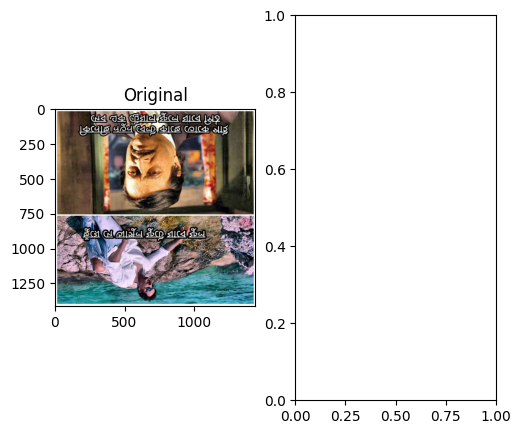

In [5]:
def visualize_augmentations():
    df = pd.read_csv(CSV_PATH)
    sample = df.sample(1).iloc[0]

    original = cv2.imread(os.path.join(IMAGE_DIR, sample['image_name']))
    augmented = [cv2.imread(os.path.join(IMAGE_DIR, f"aug_{i}_{sample['image_name']}")) for i in range(4)]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")

    for i in range(4):
        plt.subplot(1, 5, i+2)
        plt.imshow(cv2.cvtColor(augmented[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Aug {i+1}")

    plt.show()

visualize_augmentations()

# Verification

In [9]:
print(len(os.listdir(IMAGE_DIR)))  # Should return 24,240

24240


In [10]:
print(len(pd.read_csv(CSV_PATH)))  # Should return 24,240

24240
